In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import os
import cv2
import plotly.express as px
from scipy.stats import pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Part I: Data Preparation

# 1. Load and Describe the Data
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [5]:
print("Train CSV Info (8227 images):")
print(train_df.info())
print("\nTrain CSV Head:")
print(train_df.head())
print("\nTest CSV Info (2056 images):")
print(test_df.info())
print("\nTest CSV Head:")
print(test_df.head())

Train CSV Info (8227 images):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8227 entries, 0 to 8226
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_ID  8227 non-null   object
 1   label     8227 non-null   object
dtypes: object(2)
memory usage: 128.7+ KB
None

Train CSV Head:
         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket

Test CSV Info (2056 images):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_ID  2056 non-null   object
dtypes: object(1)
memory usage: 16.2+ KB
None

Test CSV Head:
         image_ID
0  f5e13966e7.jpg
1  6674191b4e.jpg
2  91b5f8b7a9.jpg
3  393119b6d6.jpg
4  1ce5f81578.jpg


In [6]:
image_col = 'image_ID'
label_col = 'label'

In [7]:
print("\nLabel Distribution:")
print(train_df[label_col].value_counts())


Label Distribution:
label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


In [8]:
# 2. Clean the Data
print("\nMissing Values in Train CSV:")
print(train_df.isnull().sum())
train_df.dropna(inplace=True)


Missing Values in Train CSV:
image_ID    0
label       0
dtype: int64


In [9]:
print("\nNumber of Duplicates in Train CSV:", train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)


Number of Duplicates in Train CSV: 0


In [10]:
def verify_images(df, folder_path):
    missing_images = []
    for idx, row in df.iterrows():
        img_path = os.path.join(folder_path, row[image_col])
        if not os.path.exists(img_path):
            missing_images.append(row[image_col])
    return missing_images

missing_train_images = verify_images(train_df, 'dataset/train')
print("\nMissing Training Images:", len(missing_train_images))
if missing_train_images:
    train_df = train_df[~train_df[image_col].isin(missing_train_images)]


Missing Training Images: 0


In [11]:
# 3. Load Images and Prepare for PCA
IMG_SIZE = 64
CHANNELS = 3  # Set to 3 for RGB; 

In [12]:
def load_images(df, folder_path, img_size=IMG_SIZE, for_pca=True):
    images = []
    labels = []
    for idx, row in df.iterrows():
        img_path = os.path.join(folder_path, row[image_col])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load as RGB (3 channels)
        # To use grayscale (1 channel), replace the above line with:
        # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            if CHANNELS == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for consistency
            if for_pca:
                images.append(img.flatten())  # Flatten: 64x64x3 = 12288 for RGB, 64x64x1 = 4096 for grayscale
            else:
                images.append(img)  # Shape: (64, 64, 3) for RGB, (64, 64) for grayscale
            labels.append(row[label_col])
    return np.array(images), np.array(labels)

In [14]:
X_pca, y = load_images(train_df, 'dataset/train', for_pca=True)
X_cnn, _ = load_images(train_df, 'dataset/train', for_pca=False)
X_cnn = X_cnn.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS)  # Shape for CNN: (samples, 64, 64, 3) for RGB
# To use grayscale, ensure CHANNELS = 1 above, and this line will reshape to (samples, 64, 64, 1)

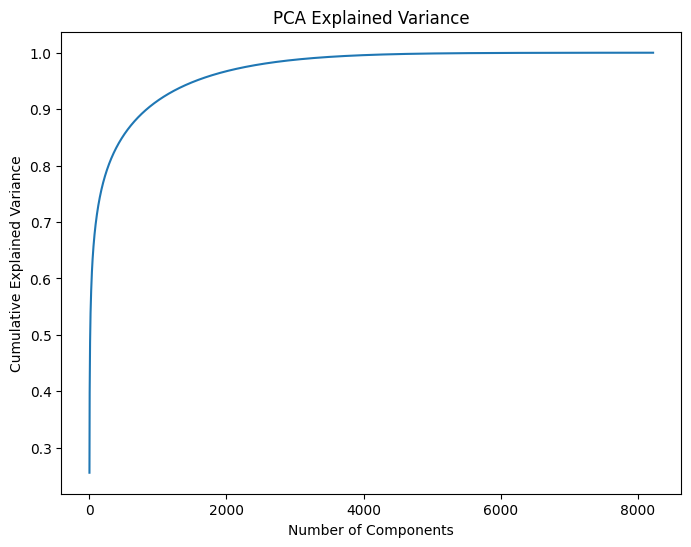


Number of components explaining 95% variance: 1549
PCA is useful: Significant dimensionality reduction achieved.


In [15]:
# 4. PCA Analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')

# Display the plot instead of saving it
plt.show()  # This will show the plot


n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1
print(f"\nNumber of components explaining 95% variance: {n_components}")
if n_components < X_pca.shape[1] * 0.5:
    print("PCA is useful: Significant dimensionality reduction achieved.")
    pca = PCA(n_components=n_components)
    X_pca_transformed = pca.fit_transform(X_scaled)
else:
    print("PCA is not useful: Most features are needed to explain variance.")
    X_pca_transformed = X_scaled

C:\Users\ELMADENA\AppData\Local\Temp\ipykernel_16336\1121978738.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Use tab10 colormap for distinct colors


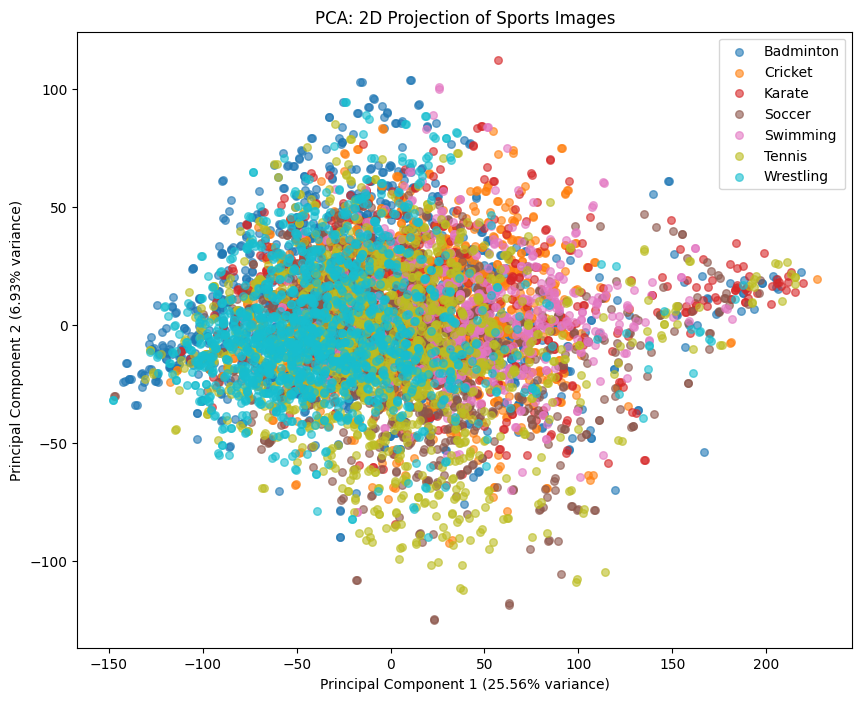

In [16]:
# Add PCA Scatter Plot: Project data onto first two components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)  # Shape: (8227, 2)

# Explained variance for the first two components
var_pc1 = pca_2d.explained_variance_ratio_[0] * 100
var_pc2 = pca_2d.explained_variance_ratio_[1] * 100

# Create a scatter plot, coloring by sport labels
plt.figure(figsize=(10, 8))
unique_labels = np.unique(y)
colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Use tab10 colormap for distinct colors

for idx, label in enumerate(unique_labels):
    mask = y == label
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                label=label, color=colors(idx), alpha=0.6, s=30)

plt.xlabel(f'Principal Component 1 ({var_pc1:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({var_pc2:.2f}% variance)')
plt.title('PCA: 2D Projection of Sports Images')
plt.legend()
plt.show()

In [26]:
# 5. Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

In [18]:
# Print original and encoded labels
print("Original Labels:", y[:10])  # Print the first 10 original labels
print("Encoded Labels:", y_encoded[:10])  # Print the first 10 encoded labels

# Print a mapping between original labels and encoded values
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label to Encoded Value Mapping:", label_mapping)

# If you want to print the reverse mapping (encoded value to original label):
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
print("Encoded Value to Label Mapping:", reverse_label_mapping)


Original Labels: ['Badminton' 'Badminton' 'Badminton' 'Badminton' 'Cricket' 'Tennis'
 'Badminton' 'Swimming' 'Badminton' 'Badminton']
Encoded Labels: [0 0 0 0 1 5 0 4 0 0]
Label to Encoded Value Mapping: {'Badminton': 0, 'Cricket': 1, 'Karate': 2, 'Soccer': 3, 'Swimming': 4, 'Tennis': 5, 'Wrestling': 6}
Encoded Value to Label Mapping: {0: 'Badminton', 1: 'Cricket', 2: 'Karate', 3: 'Soccer', 4: 'Swimming', 5: 'Tennis', 6: 'Wrestling'}


In [19]:
# 6. Split Data for CNN
X_train, X_val, y_train, y_val = train_test_split(X_cnn, y_encoded, test_size=0.2, random_state=42)

In [20]:
# Compute the mean and standard deviation for the training set
train_mean = np.mean(X_train, axis=(0, 1, 2))  # Mean for each channel (RGB)
train_std = np.std(X_train, axis=(0, 1, 2))  # Std for each channel (RGB)

# Standardize the data using the mean and std computed from the training set
X_train_standardized = (X_train - train_mean) / train_std
X_val_standardized = (X_val - train_mean) / train_std  # Use the training set's mean and std for validation set

# Define the ImageDataGenerators for data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()  # No augmentation for validation set

# Apply the standardization (mean subtraction and division by std) to the train and validation sets
train_generator = train_datagen.flow(X_train_standardized, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_standardized, y_val, batch_size=32)


In [21]:
# 5. Check Consistency Between Training and Validation Data Standardization
print("\nEnsure that the training and validation data have similar mean and standard deviation:")
print("Training Mean:", np.mean(X_train_standardized, axis=(0, 1, 2)))
print("Validation Mean:", np.mean(X_val_standardized, axis=(0, 1, 2)))

print("\nTraining Std:", np.std(X_train_standardized, axis=(0, 1, 2)))
print("Validation Std:", np.std(X_val_standardized, axis=(0, 1, 2)))


Ensure that the training and validation data have similar mean and standard deviation:
Training Mean: [-3.73969275e-15 -8.25435816e-14 -1.51779409e-14]
Validation Mean: [-0.01077603 -0.00417199 -0.01862566]

Training Std: [1. 1. 1.]
Validation Std: [0.99881143 1.00159806 0.99471388]


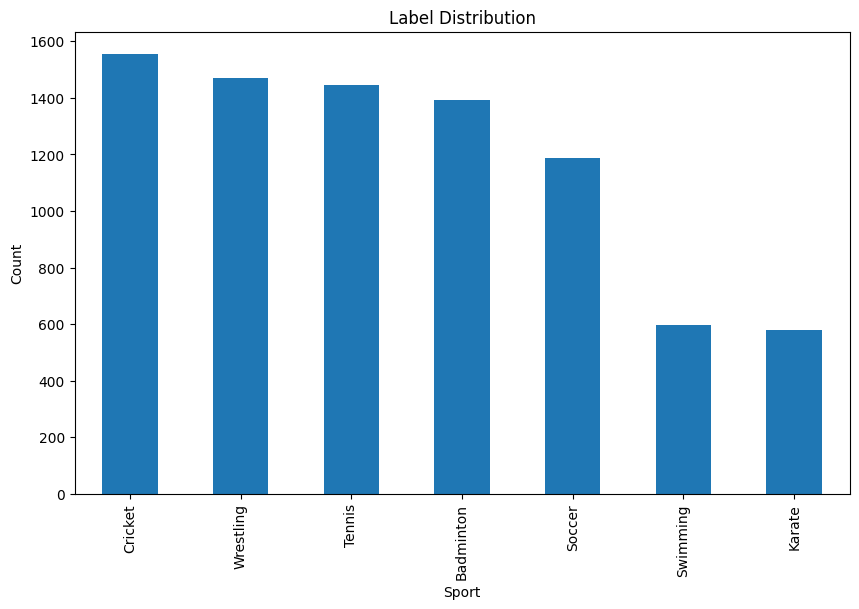

In [54]:
#visualize all data (not train data only )
plt.figure(figsize=(10, 6))
train_df[label_col].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Sport')
plt.ylabel('Count')

# Show the plot in the notebook instead of saving it
plt.show()



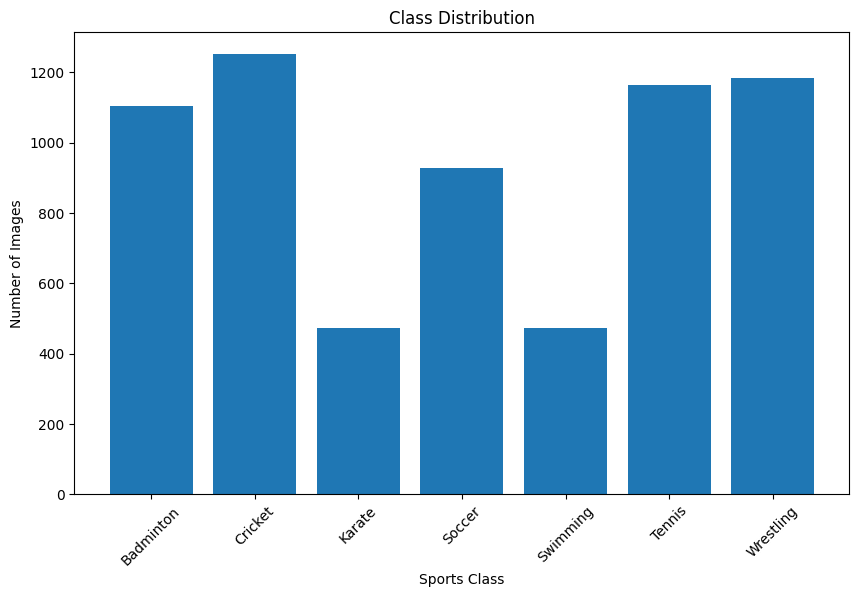

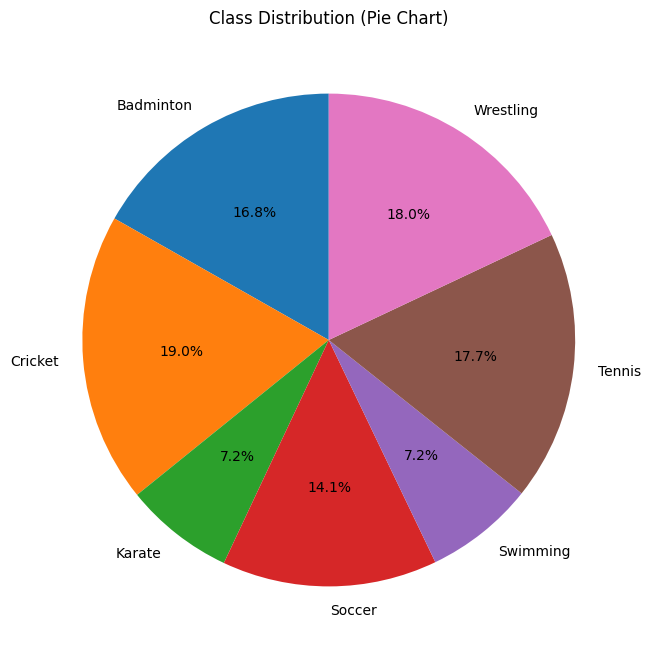

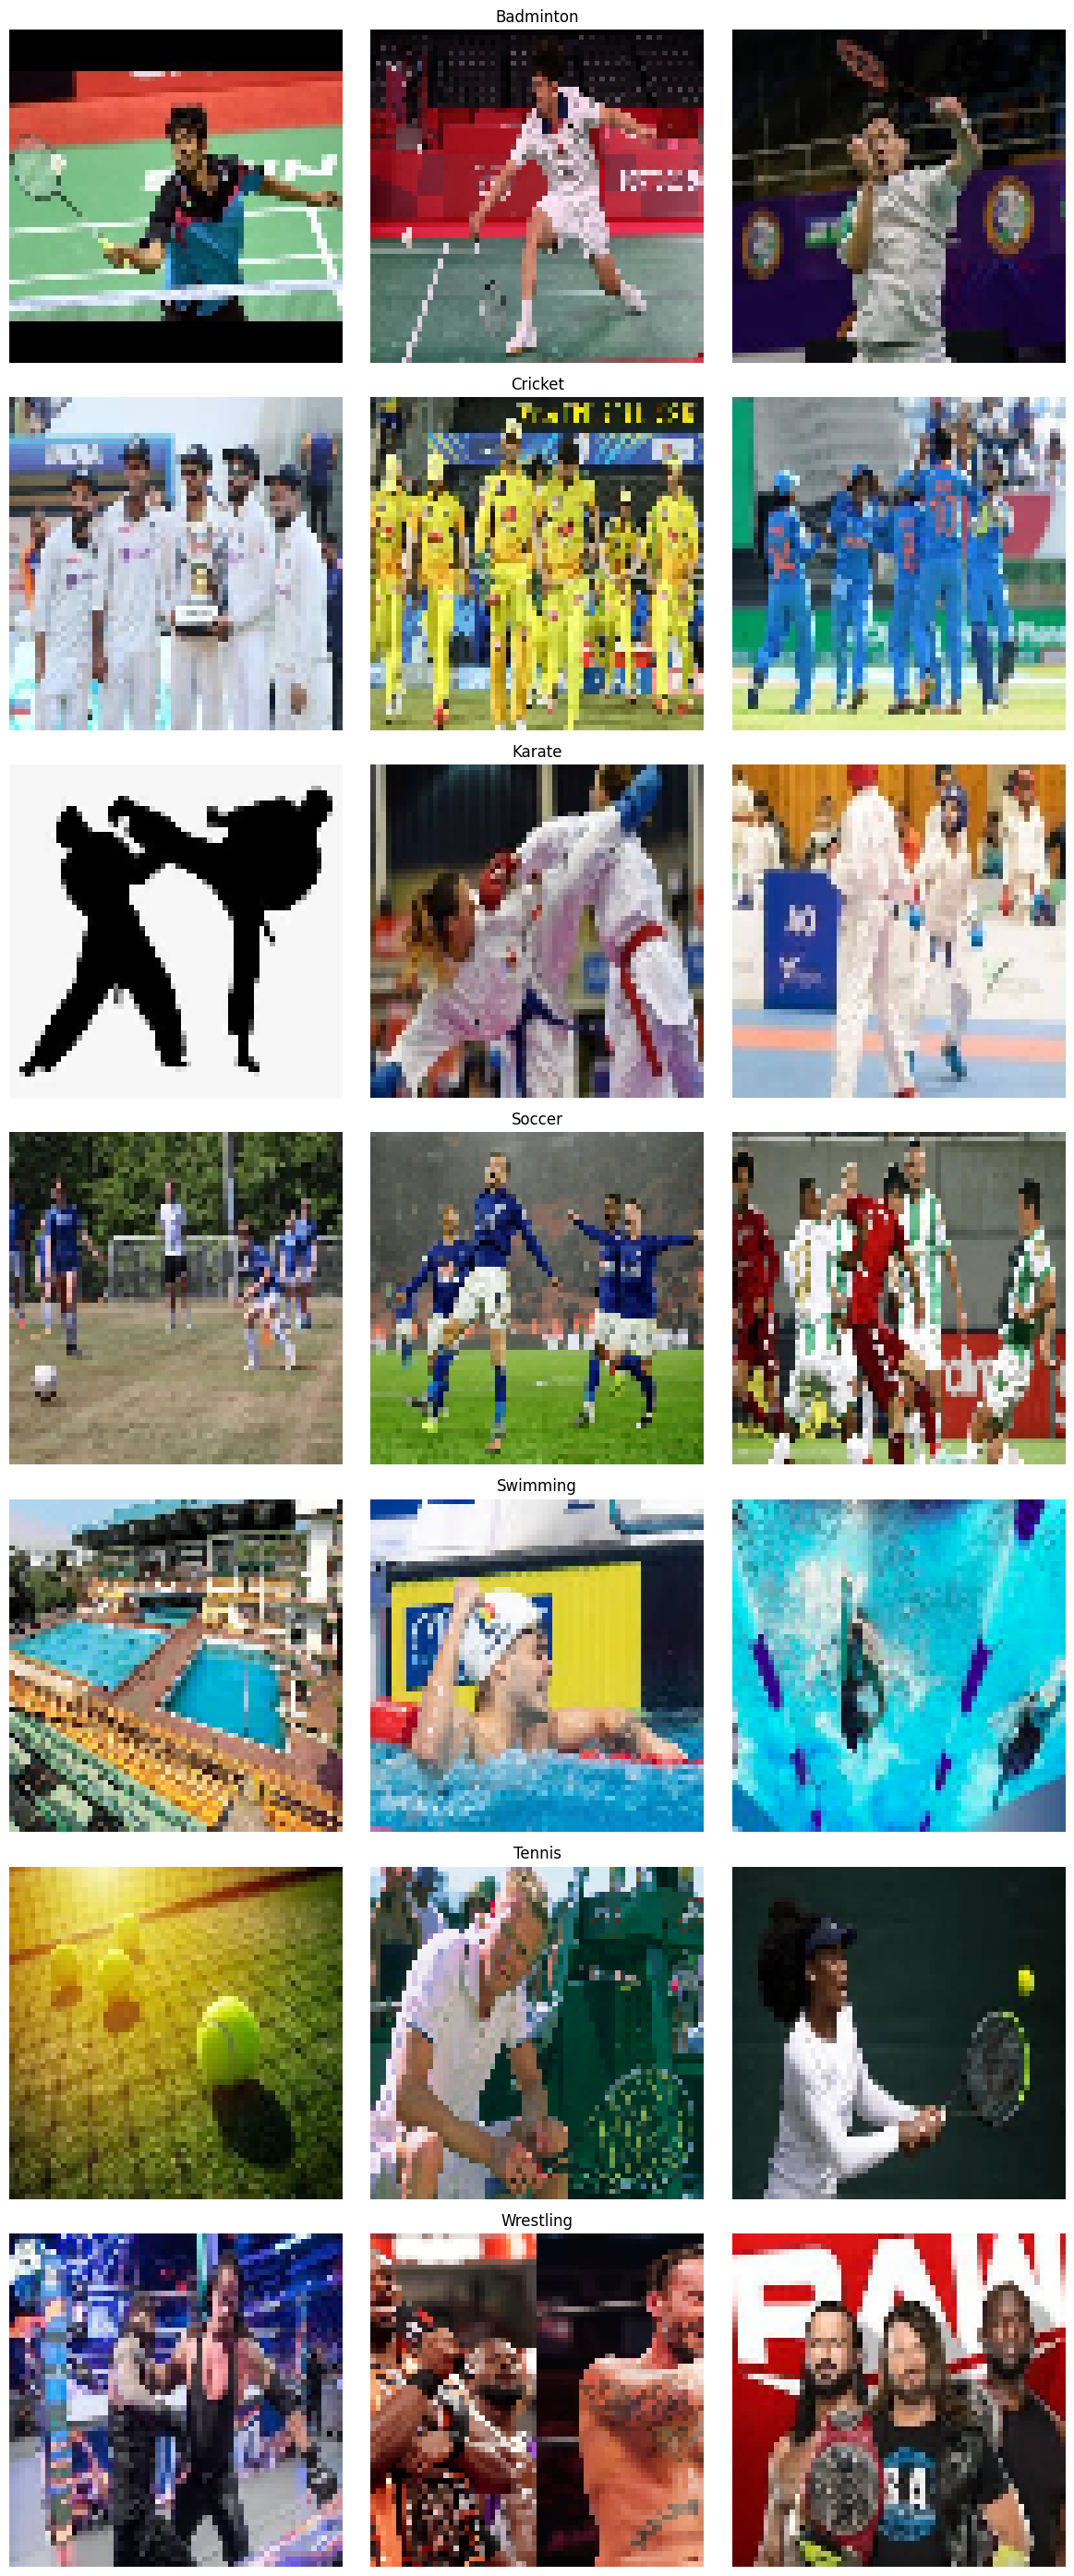

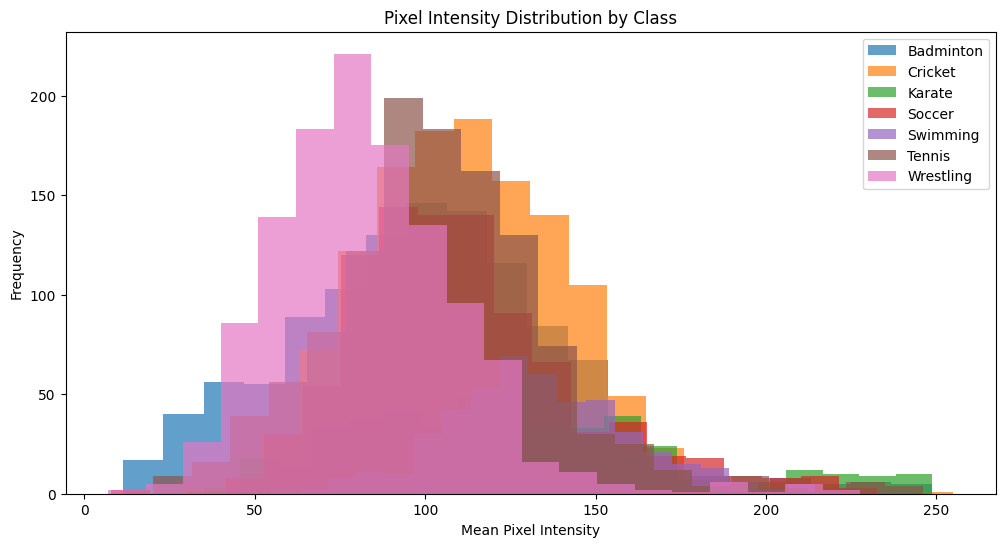

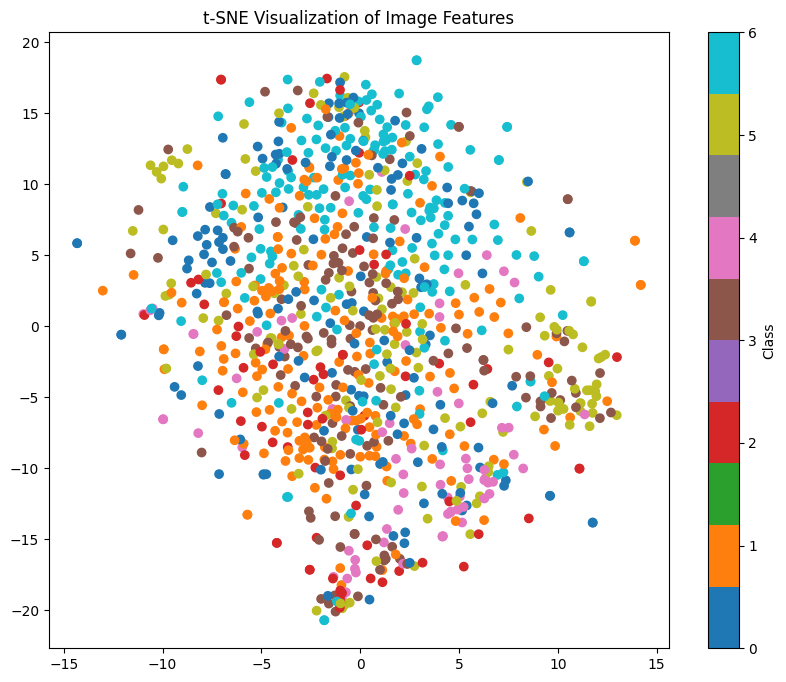

In [72]:
# 8. Visualize Data
def visualize_data(train_images, train_labels, class_names):

    # # Existing: Label distribution bar chart
    plt.figure(figsize=(10, 6))
    unique, counts = np.unique(y_train, return_counts=True)
    plt.bar(class_names, counts)
    plt.title('Class Distribution')
    plt.xlabel('Sports Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    # New: Pie chart for class distribution
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.title('Class Distribution (Pie Chart)')
    plt.show()

    # New: Image montage by class
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, 3, figsize=(12, 4 * num_classes))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(train_labels == i)[0]
        sample_indices = np.random.choice(class_indices, 3, replace=False)
        for j, idx in enumerate(sample_indices):
            axes[i, j].imshow(train_images[idx])
            axes[i, j].axis('off')
            if j == 1:
                axes[i, j].set_title(f'{class_name}')
    plt.tight_layout()
    plt.show()

    # New: Pixel intensity histograms
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(class_names):
        class_images = train_images[train_labels == i]
        mean_intensities = np.mean(class_images, axis=(1, 2, 3))  # Averaging over the image dimensions
        plt.hist(mean_intensities, bins=20, alpha=0.7, label=class_name,)
    plt.title('Pixel Intensity Distribution by Class')
    plt.xlabel('Mean Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # New: t-SNE visualization (subsample for speed)
    subsample_size = min(1000, len(train_images))
    subsample_indices = np.random.choice(len(train_images), subsample_size, replace=False)
    features_subsample = train_images[subsample_indices]  # Selecting a subset of images
    labels_subsample = train_labels[subsample_indices]

    # Flatten the images for t-SNE (reshape from 4D to 2D)
    features_subsample = features_subsample.reshape(subsample_size, -1)  # Flatten each image

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features_subsample)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_subsample, cmap='tab10')
    plt.colorbar(scatter, ticks=range(len(class_names)), label='Class')
    plt.title('t-SNE Visualization of Image Features')
    plt.show()

# Example usage
visualize_data(X_train, y_train, class_names)

In [74]:
# 9. Correlation Analysis (Interactive HTML Heatmap with Negative Correlations)
# Compute correlation matrix
pixel_corr = pd.DataFrame(X_pca).iloc[::5, ::5].corr()  # Shape: (2458, 2458)

# Check for negative correlations in the first subsampled matrix
print("\nChecking for negative correlations in first subsampled matrix:")
negative_corrs = pixel_corr[pixel_corr < 0].stack()
if not negative_corrs.empty:
    print(f"Found {len(negative_corrs)} negative correlations. Sample:")
    print(negative_corrs.head())
else:
    print("No negative correlations found.")

# Subsample to reduce size while ensuring negative correlations are included
step = 100  # Reduces from 2458 to ~25 (2458 / 100)
# Select indices to include some negative correlations
# Find pairs with negative correlations
neg_pairs = np.where(pixel_corr < -0.1)  # Threshold to find significant negative correlations
neg_indices = list(set(neg_pairs[0]))  # Unique indices with negative correlations

# Ensure we include some indices with negative correlations
num_indices_to_include = min(5, len(neg_indices))  # Include up to 5 indices with negative correlations
selected_neg_indices = neg_indices[:num_indices_to_include] if neg_indices else []

# Create a list of indices for subsampling, including negative correlation indices
subsample_indices = list(range(0, pixel_corr.shape[0], step))  # Default subsampling: 0, 100, ..., 2400
# Add some indices with negative correlations
for idx in selected_neg_indices:
    closest_subsample_idx = (idx // step) * step  # Align with step
    if closest_subsample_idx not in subsample_indices:
        subsample_indices.append(closest_subsample_idx)

subsample_indices = sorted(set(subsample_indices))  # Remove duplicates and sort
subsample_indices = subsample_indices[:25]  # Limit to 25 indices to keep heatmap manageable

# Subsample the correlation matrix using selected indices
subsampled_corr = pixel_corr.iloc[subsample_indices, subsample_indices].values

# Map subsampled indices back to original indices
original_indices = np.array(subsample_indices) * 5  # Map to original feature space: [0, 500, ..., 12000]

# Create tick labels for the heatmap
num_ticks = min(10, len(original_indices))
tick_positions = np.linspace(0, len(original_indices) - 1, num_ticks).astype(int)
tick_labels = original_indices[tick_positions]

# Create text annotations (rounded correlation values)
text_annotations = np.round(subsampled_corr, 2).astype(str)

# Create interactive heatmap with Plotly
fig = go.Figure(data=go.Heatmap(
    z=subsampled_corr,
    x=original_indices,
    y=original_indices,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    colorbar=dict(title='Correlation'),
    text=text_annotations,
    texttemplate="%{text}",
    textfont=dict(size=10),
))

fig.update_layout(
    title='Pixel Correlation Heatmap (Subsampled)',
    xaxis_title='Pixel Index (Subsampled)',
    yaxis_title='Pixel Index (Subsampled)',
    xaxis=dict(tickvals=tick_labels, ticktext=[str(val) for val in tick_labels]),
    yaxis=dict(tickvals=tick_labels, ticktext=[str(val) for val in tick_labels]),
    autosize=True,
    margin=dict(l=50, r=50, t=100, b=50),
)

fig.write_html(
    'pixel_correlation_interactive.html',
    include_plotlyjs='cdn',
    post_script="""
    const style = document.createElement('style');
    style.innerHTML = `
        #graph { width: 100vw !important; height: 100vh !important; }
        body { margin: 0; padding: 0; overflow: hidden; }
    `;
    document.head.appendChild(style);
    """
)
print("\nInteractive heatmap saved as 'pixel_correlation_interactive.html'")
print("Open the HTML file in a browser to view the full-screen heatmap .")


Checking for negative correlations in first subsampled matrix:
Found 6 negative correlations. Sample:
2635   11835   -0.002409
3020   11835   -0.007049
7960   11835   -0.006249
11835  2635    -0.002409
       3020    -0.007049
dtype: float64

Interactive heatmap saved as 'pixel_correlation_interactive.html'
Open the HTML file in a browser to view the full-screen heatmap .


In [ ]:
# Part II: Training a Neural Network
def create_cnn_model(num_layers=2, dropout_rate=0.2, weight_decay=0.0):
    model = keras.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS)))
    
    for i in range(num_layers):
        model.add(layers.Conv2D(filters=32 * (2**i), kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(len(np.unique(y_encoded)), activation='softmax'))
    
    return model

def train_model(model, optimizer, batch_size, epochs=50):
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Early Stopping to stop training when the validation loss is not improving
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    
    # Learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    
    # TensorBoard callback
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback],
        verbose=1
    )
    return history


def evaluate_model(model):
    train_loss, train_acc = model.evaluate(train_generator, verbose=0)
    val_loss, val_acc = model.evaluate(val_generator, verbose=0)
    print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    return train_acc, val_acc

# Hyperparameter Exploration
batch_sizes = [32, 64]
num_layers = [2, 3]
dropout_rates = [0.2, 0.4]
optimizers = [
    keras.optimizers.Adam(learning_rate=0.001),
    keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    keras.optimizers.RMSprop(learning_rate=0.001)
]
weight_decays = [0.0, 0.01]

results = []
default_batch_size = 32
default_num_layers = 2
default_dropout_rate = 0.2
default_optimizer = keras.optimizers.Adam(learning_rate=0.001)
default_weight_decay = 0.0

def update_generators(batch_size):
    global train_generator, val_generator
    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

print("\nExploring Batch Sizes:")
for bs in batch_sizes:
    update_generators(bs)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=default_dropout_rate, weight_decay=default_weight_decay)
    history = train_model(model, default_optimizer, bs)
    train_acc, val_acc = evaluate_model(model)
    results.append({'batch_size': bs, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Batch Size: {bs})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Batch Size: {bs})')
    plt.legend()
    plt.savefig(f'batch_size_{bs}_curves.png')
    plt.close()

print("\nExploring Number of Layers:")
for nl in num_layers:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=nl, dropout_rate=default_dropout_rate, weight_decay=default_weight_decay)
    history = train_model(model, default_optimizer, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'num_layers': nl, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Layers: {nl})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Layers: {nl})')
    plt.legend()
    plt.savefig(f'layers_{nl}_curves.png')
    plt.close()

print("\nExploring Dropout Rates:")
for dr in dropout_rates:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=dr, weight_decay=default_weight_decay)
    history = train_model(model, default_optimizer, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'dropout_rate': dr, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Dropout: {dr})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Dropout: {dr})')
    plt.legend()
    plt.savefig(f'dropout_{dr}_curves.png')
    plt.close()

print("\nExploring Optimizers:")
for opt in optimizers:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=default_dropout_rate, weight_decay=default_weight_decay)
    history = train_model(model, opt, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'optimizer': opt.__class__.__name__, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Optimizer: {opt.__class__.__name__})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Optimizer: {opt.__class__.__name__})')
    plt.legend()
    plt.savefig(f'optimizer_{opt.__class__.__name__}_curves.png')
    plt.close()

print("\nExploring Weight Decay:")
for wd in weight_decays:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=default_dropout_rate, weight_decay=wd)
    history = train_model(model, default_optimizer, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'weight_decay': wd, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Weight Decay: {wd})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Weight Decay: {wd})')
    plt.legend()
    plt.savefig(f'weight_decay_{wd}_curves.png')
    plt.close()

print("\nSummary of Results:")
for result in results:
    print(result)

# Find the best result based on validation accuracy
best_result = max(results, key=lambda x: x.get('val_acc', 0))
print("\nBest Configuration:", best_result)

# Extract the best hyperparameters
best_batch_size = best_result.get('batch_size', default_batch_size)
best_num_layers = best_result.get('num_layers', default_num_layers)
best_dropout_rate = best_result.get('dropout_rate', default_dropout_rate)
best_weight_decay = best_result.get('weight_decay', default_weight_decay)
best_optimizer_name = best_result.get('optimizer', 'Adam')

# Find the optimizer instance
best_optimizer = next(opt for opt in optimizers if opt.__class__.__name__ == best_optimizer_name)

# Train the best model with the optimal hyperparameters
update_generators(best_batch_size)
best_model = create_cnn_model(num_layers=best_num_layers, dropout_rate=best_dropout_rate, weight_decay=best_weight_decay)
train_model(best_model, best_optimizer, best_batch_size)

# Save the best model
best_model.save('best_sports_classifier.h5')
print("\nBest model saved as 'best_sports_classifier.h5'")

# Load test data and make predictions
X_test, _ = load_images(test_df, 'dataset/test', for_pca=False)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test, batch_size=32, shuffle=False)

predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = le.inverse_transform(predicted_classes)

submission_df = pd.DataFrame({
    'filename': test_df[image_col],
    'label': predicted_labels
})
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file created: submission.csv")

# This only a dummy Cells for Debugging 

In [ ]:
\# Part II: Training a Neural Network

# Requirement 1: Implement a CNN model
def create_cnn_model(num_layers=2, dropout_rate=0.2, weight_decay=0.0):
    model = keras.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS)))
    
    for i in range(num_layers):
        model.add(layers.Conv2D(filters=32 * (2**i), kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(len(np.unique(y_encoded)), activation='softmax'))
    
    return model

# Requirement 2: Write a training function
def train_model(model, optimizer, batch_size, epochs=50):
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[lr_scheduler, tensorboard_callback],
        verbose=1
    )
    return history

# Requirement 3: Evaluate the model
def evaluate_model(model):
    train_loss, train_acc = model.evaluate(train_generator, verbose=0)
    val_loss, val_acc = model.evaluate(val_generator, verbose=0)
    print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    return train_acc, val_acc

# Requirement 4: Explore hyperparameters
# Define hyperparameters to explore
batch_sizes = [32, 64]
num_layers = [2, 3]
dropout_rates = [0.2, 0.4]
optimizers = [
    keras.optimizers.Adam(learning_rate=0.001),
    keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    keras.optimizers.RMSprop(learning_rate=0.001)
]
weight_decays = [0.0, 0.01]

results = []
default_batch_size = 32
default_num_layers = 2
default_dropout_rate = 0.2
default_optimizer = keras.optimizers.Adam(learning_rate=0.001)
default_weight_decay = 0.0

def update_generators(batch_size):
    global train_generator, val_generator
    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# Explore batch sizes
print("\nExploring Batch Sizes:")
for bs in batch_sizes:
    update_generators(bs)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=default_dropout_rate, weight_decay=default_weight_decay)
    history = train_model(model, default_optimizer, bs)
    train_acc, val_acc = evaluate_model(model)
    results.append({'batch_size': bs, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Batch Size: {bs})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Batch Size: {bs})')
    plt.legend()
    plt.savefig(f'batch_size_{bs}_curves.png')
    plt.close()

# Explore number of layers
print("\nExploring Number of Layers:")
for nl in num_layers:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=nl, dropout_rate=default_dropout_rate, weight_decay=default_weight_decay)
    history = train_model(model, default_optimizer, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'num_layers': nl, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Layers: {nl})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Layers: {nl})')
    plt.legend()
    plt.savefig(f'layers_{nl}_curves.png')
    plt.close()

# Explore dropout rates
print("\nExploring Dropout Rates:")
for dr in dropout_rates:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=dr, weight_decay=default_weight_decay)
    history = train_model(model, default_optimizer, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'dropout_rate': dr, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Dropout: {dr})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Dropout: {dr})')
    plt.legend()
    plt.savefig(f'dropout_{dr}_curves.png')
    plt.close()

# Explore optimizers
print("\nExploring Optimizers:")
for opt in optimizers:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=default_dropout_rate, weight_decay=default_weight_decay)
    history = train_model(model, opt, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'optimizer': opt.__class__.__name__, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Optimizer: {opt.__class__.__name__})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Optimizer: {opt.__class__.__name__})')
    plt.legend()
    plt.savefig(f'optimizer_{opt.__class__.__name__}_curves.png')
    plt.close()

# Explore weight decays
print("\nExploring Weight Decay:")
for wd in weight_decays:
    update_generators(default_batch_size)
    model = create_cnn_model(num_layers=default_num_layers, dropout_rate=default_dropout_rate, weight_decay=wd)
    history = train_model(model, default_optimizer, default_batch_size)
    train_acc, val_acc = evaluate_model(model)
    results.append({'weight_decay': wd, 'train_acc': train_acc, 'val_acc': val_acc})
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Accuracy (Weight Decay: {wd})')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Loss (Weight Decay: {wd})')
    plt.legend()
    plt.savefig(f'weight_decay_{wd}_curves.png')
    plt.close()

# Requirement 5: Summarize results
print("\nSummary of Results:")
for result in results:
    print(result)

# Requirement 6: Find the best configuration
best_result = max(results, key=lambda x: x.get('val_acc', 0))
print("\nBest Configuration:", best_result)

# Requirement 7: Extract the best hyperparameters
best_batch_size = best_result.get('batch_size', default_batch_size)
best_num_layers = best_result.get('num_layers', default_num_layers)
best_dropout_rate = best_result.get('dropout_rate', default_dropout_rate)
best_weight_decay = best_result.get('weight_decay', default_weight_decay)
best_optimizer_name = best_result.get('optimizer', 'Adam')

# Find the optimizer instance
best_optimizer = next(opt for opt in optimizers if opt.__class__.__name__ == best_optimizer_name)

# Requirement 8: Train the best model
update_generators(best_batch_size)
best_model = create_cnn_model(num_layers=best_num_layers, dropout_rate=best_dropout_rate, weight_decay=best_weight_decay)
train_model(best_model, best_optimizer, best_batch_size)

# Requirement 9: Save the best model
best_model.save('best_sports_classifier.h5')
print("\nBest model saved as 'best_sports_classifier.h5'")

# Requirement 10: Load test data and make predictions for submission
X_test, _ = load_images(test_df, 'dataset/test', for_pca=False)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test, batch_size=32, shuffle=False)

predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = le.inverse_transform(predicted_classes)

submission_df = pd.DataFrame({
    'filename': test_df[image_col],
    'label': predicted_labels
})
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file created: submission.csv")